In [4]:
from vnstock import *
import numpy as np
from datetime import datetime 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from pyti.exponential_moving_average import exponential_moving_average as ema

In [5]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

In [6]:
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

In [7]:
df = stock_historical_data("HPG", "2019-01-01",str(datetime.now())[:10])
benchmark = stock_historical_data("E1VFVN30","2019-01-01",str(datetime.now())[:10])
print(df.tail())

         Open     High      Low    Close    Volume TradingDate
1033  21150.0  21500.0  20400.0  21500.0  33600491  2023-02-23
1034  21500.0  21500.0  20650.0  20800.0  14604476  2023-02-24
1035  20400.0  20550.0  19950.0  20100.0  31325056  2023-02-27
1036  20450.0  20500.0  19900.0  20000.0  15225174  2023-02-28
1037  20000.0  20650.0  19800.0  20650.0  16420600  2023-03-01


In [41]:
df_2022=df[df['TradingDate']>='2022']
benchmark_2022=benchmark[benchmark['TradingDate']>='2022']

In [42]:
df_2022.isna().sum()

Open           0
High           0
Low            0
Close          0
Volume         0
TradingDate    0
dtype: int64

In [43]:
df_2022.set_index('TradingDate',inplace=True)
df.set_index('TradingDate',inplace=True)
benchmark_2022.set_index('TradingDate',inplace=True)

In [44]:
ema = ema(df_2022['Close'].tolist(),20)

In [45]:
len(ema)

286

In [46]:
up = df_2022[df_2022.Close >= df_2022.Open]
down = df_2022[df_2022.Close < df_2022.Open]
width1=1
width2=.3
col1='green'
col2='red'

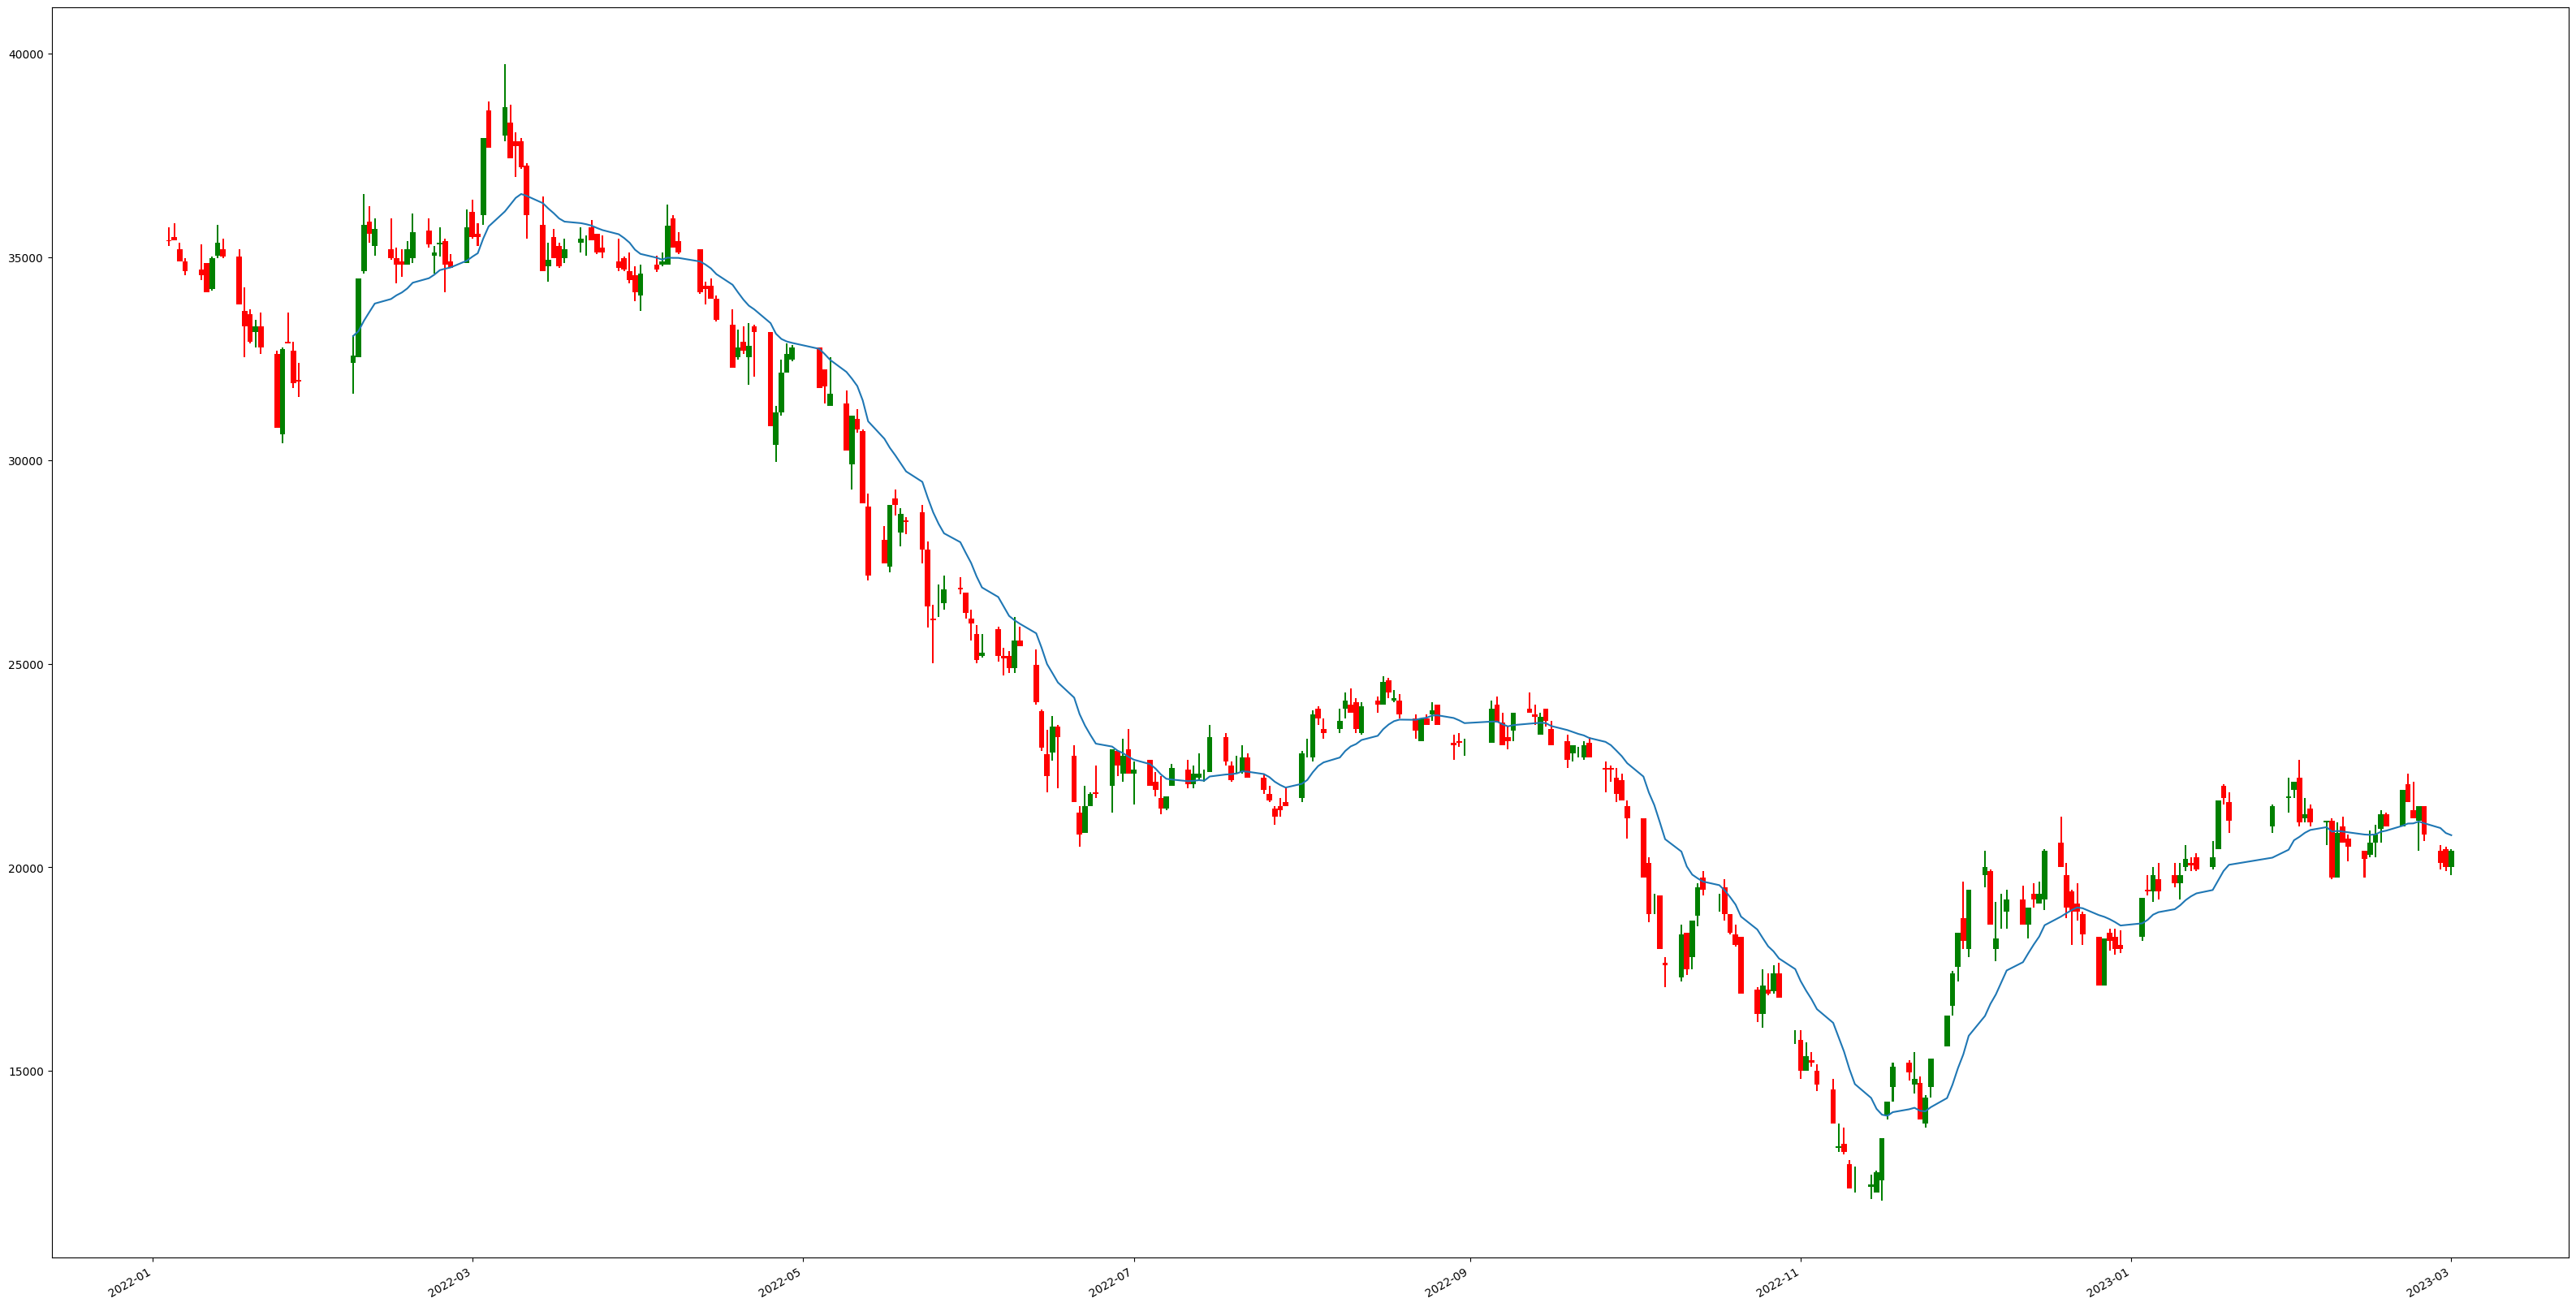

In [47]:
plt.figure(figsize=(40,20))
plt.plot(df_2022.index,ema)
plt.bar(up.index, up.Close-up.Open,width1, bottom=up.Open, color=col1)
plt.bar(up.index, up.High-up.Close,width2,  bottom=up.Close, color=col1)
plt.bar(up.index, up.Low-up.Open,width2,  bottom=up.Open, color=col1)
plt.bar(down.index, down.Close-down.Open,width1, bottom=down.Open, color=col2)
plt.bar(down.index, down.High-down.Open,width2,  bottom=down.Open, color=col2)
plt.bar(down.index, down.Low-down.Close, width2, bottom=down.Close, color=col2)
  
plt.xticks(rotation=30, ha='right')
plt.show()

(array([-0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,  0.08]),
 [Text(-0.08, 0, '−0.08'),
  Text(-0.06, 0, '−0.06'),
  Text(-0.04, 0, '−0.04'),
  Text(-0.020000000000000004, 0, '−0.02'),
  Text(0.0, 0, '0.00'),
  Text(0.020000000000000004, 0, '0.02'),
  Text(0.039999999999999994, 0, '0.04'),
  Text(0.06000000000000001, 0, '0.06'),
  Text(0.08, 0, '0.08')])

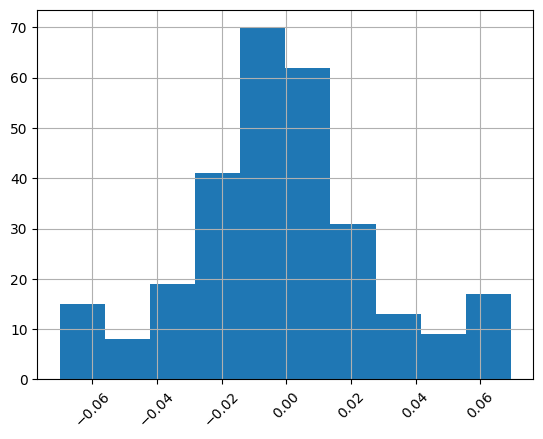

In [48]:

change_close_stock = df_2022['Close'].pct_change()
change_close_benchmark = benchmark_2022['Close'].pct_change()
change_close_stock.hist()
plt.xticks(rotation=45)

In [49]:
change_close_stock.skew()
#tính độ lệch 

0.1637800883347754

In [50]:
change_close_stock.kurtosis()
#tính độ nhọn

0.5009467320612488

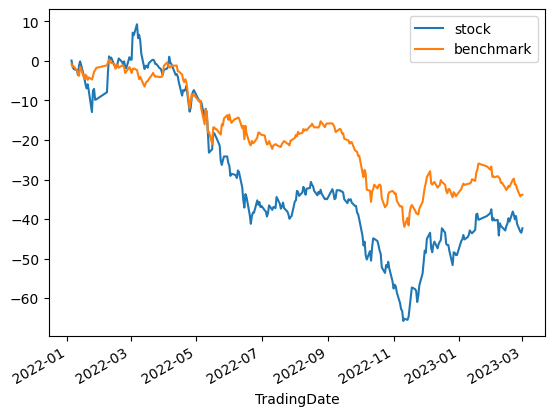

In [51]:
cumprod_change_close_stock=change_close_stock +1
cumprod_change_close_stock = cumprod_change_close_stock.cumprod().sub(1)
cumprod_change_close_benchmark=change_close_benchmark +1
cumprod_change_close_benchmark = cumprod_change_close_benchmark.cumprod().sub(1)
cumprod_change_close_stock.mul(100).plot(label='stock')
cumprod_change_close_benchmark.mul(100).plot(label='benchmark')
plt.legend()
plt.show()
#tính số lãi tích lũy

In [52]:
sd_change_close_stock=change_close_stock.std()
sd_change_close_stock

0.029552307956698144

<AxesSubplot: xlabel='TradingDate'>

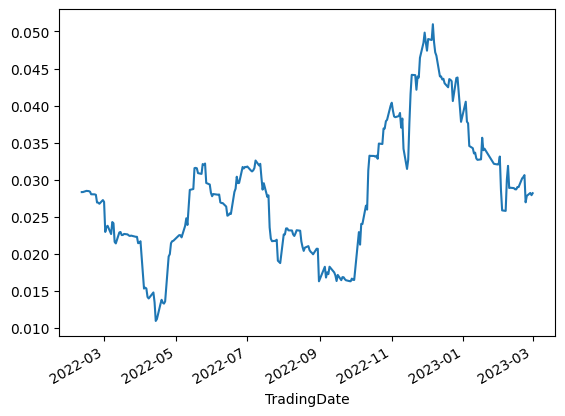

In [53]:
volatility=change_close_stock.rolling(22).std()
volatility.plot()
#tính độ biến động của cổ phiếu

In [54]:
#tinhs beta
a = cumprod_change_close_stock.loc[::22]
stock_diff = a.diff().dropna()
b = cumprod_change_close_benchmark.loc[::22]
benchmark_diff = b.diff().dropna()
covariance = np.cov(stock_diff, benchmark_diff)[0,1]
variance = np.var(stock_diff)
beta=covariance/variance
beta*100


68.1863802409281

In [55]:
#tính sharpe ratio
month_return = ((cumprod_change_close_stock[-1]+1)**(22/len(cumprod_change_close_stock)))-1
sharpe_ratio = month_return/(sd_change_close_stock*np.sqrt(22))
sharpe_ratio

-0.29918144282643294

In [57]:
#tính VaR(value at Risk) giá trị ở rủi ro
np.random.seed(42)
boot_distn = []
for i in range(5000):
    a=np.mean(
        df_2022['Close'].sample(frac=1,replace=True)
    )
    boot_distn.append(a)
std_error = np.std(boot_distn,ddof=1)
mean_boot_distn = np.mean(boot_distn)
z_score = (mean_boot_distn-df_2022['Close'].mean())/(std_error)
VaR= abs(z_score)*df_2022['Close'][-1]*df_2022['Close'].std()
VaR

2350286.4395776265

In [ ]:
#từ đây ta thấy hiện nay đầu tư là rất mạo hiểm chưa nên(rủi ro cao)

In [ ]:
#mu_ema = expected_returns.ema_historical_return(df['Close'],span=22,frequency=252)
#sigma_ew = risk_models.exp_cov(df['Close'],span=22,frequency=252)
#ef = EfficientFrontier(mu_ema,sigma_ew)
#ef.efficient_risk(0.3)
#perf_max_sharpe_EW = ef.portfolio_performance(verbose=True)

In [ ]:
#tính close với volume độc lập hay không
# sharpe ratio của cái này
#Nên hay không
#lstm

LSTM

In [9]:
training_set = df['Close'][:-66].values.reshape(-1,1)
len(training_set)

972

In [10]:
test_set = df["Close"][len(training_set)-len(df):].values.reshape(-1,1)
len(test_set)

66

In [11]:
# Thuc hien scale du lieu gia ve khoang 0,1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.fit_transform(test_set)
len(training_set_scaled)
len(test_set_scaled)

66

In [12]:
# Tao du lieu train, X = 22 time steps, Y =  1 time step
X_train = []
y_train = []
no_of_sample = len(training_set)

for i in range(22, no_of_sample):
    X_train.append(training_set_scaled[i-22:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(950, 22, 1)

In [58]:
# Tao du lieu test, x=22,y=1
X_test = []
Y_test = []
no_of_sample = len(test_set)

for i in range(22, no_of_sample):
    X_test.append(test_set_scaled[i-22:i, 0])
    Y_test.append(test_set_scaled[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(44, 22, 1)

In [28]:
def create_model(units,dropout_rate,activation,optimizer,epochs):
    # Xay dung model LSTM
    regressor = Sequential()
    regressor.add(LSTM(units = units, return_sequences = True, input_shape = (22, 1) ))
    regressor.add(Dropout(dropout_rate))
    for i in range(epochs):
        regressor.add(LSTM(units = units, return_sequences = True))
        regressor.add(Dropout(dropout_rate))
    regressor.add(LSTM(units = units))
    regressor.add(Dropout(dropout_rate))
    regressor.add(Dense(units = 1,activation=activation))
    regressor.compile(optimizer = optimizer, loss = 'mean_squared_error',metrics=['accuracy'])
    return regressor


In [29]:
model = KerasRegressor(build_fn=create_model,verbose=0)
units = [20,22,25,30]
epochs=[5,10,15]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4]
activation = ['relu', 'tanh']
optimizer = [ 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(units=units, dropout_rate=dropout_rate, activation=activation,
                 optimizer=optimizer,epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train,verbose=1)
# perform the grid search

# print the best parameters and score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\Nhat Nam\AppData\Local\Temp\ipykernel_17720\3948069746.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model,verbose=0)


Epoch 1/5
20/20 [==============================] - 13s 62ms/step - loss: 0.3337 - accuracy: 0.0000e+00
Epoch 2/5
20/20 [==============================] - 1s 51ms/step - loss: 0.3329 - accuracy: 0.0000e+00
Epoch 3/5
20/20 [==============================] - 1s 39ms/step - loss: 0.3319 - accuracy: 0.0000e+00
Epoch 4/5
20/20 [==============================] - 1s 41ms/step - loss: 0.3310 - accuracy: 0.0000e+00
Epoch 5/5
20/20 [==============================] - 1s 39ms/step - loss: 0.3300 - accuracy: 0.0000e+00
Epoch 1/5
20/20 [==============================] - 12s 33ms/step - loss: 0.2254 - accuracy: 0.0016
Epoch 2/5
20/20 [==============================] - 1s 39ms/step - loss: 0.2254 - accuracy: 0.0016
Epoch 3/5
20/20 [==============================] - 1s 37ms/step - loss: 0.2254 - accuracy: 0.0016
Epoch 4/5
20/20 [==============================] - 1s 41ms/step - loss: 0.2254 - accuracy: 0.0016
Epoch 5/5
20/20 [==============================] - 1s 40ms/step - loss: 0.2254 - accuracy: 0.001

In [30]:
model = create_model(units=25,activation='tanh',dropout_rate=0.2,epochs=5,optimizer='Adamax')


In [31]:
h = model.fit(x=X_train, y=y_train, epochs = 50,verbose=1)

Epoch 1/50
30/30 [==============================] - 19s 45ms/step - loss: 0.0797 - accuracy: 0.0021
Epoch 2/50
30/30 [==============================] - 1s 42ms/step - loss: 0.0117 - accuracy: 0.0021
Epoch 3/50
30/30 [==============================] - 2s 57ms/step - loss: 0.0076 - accuracy: 0.0021
Epoch 4/50
30/30 [==============================] - 2s 50ms/step - loss: 0.0063 - accuracy: 0.0021
Epoch 5/50
30/30 [==============================] - 1s 46ms/step - loss: 0.0063 - accuracy: 0.0021
Epoch 6/50
30/30 [==============================] - 1s 43ms/step - loss: 0.0058 - accuracy: 0.0021
Epoch 7/50
30/30 [==============================] - 1s 42ms/step - loss: 0.0057 - accuracy: 0.0021
Epoch 8/50
30/30 [==============================] - 1s 43ms/step - loss: 0.0060 - accuracy: 0.0021
Epoch 9/50
30/30 [==============================] - 1s 41ms/step - loss: 0.0057 - accuracy: 0.0021
Epoch 10/50
30/30 [==============================] - 1s 39ms/step - loss: 0.0061 - accuracy: 0.0021
Epoch 11

In [35]:
prediction = model.predict(X_test)

2/2 [==============================] - 36s 59ms/step


In [73]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(Y_test, prediction)
Accuracy = 1 - MAPE
Accuracy

0.8482149468852903

In [29]:
# Tien hanh du doan
inputs = df['Close'][len(df) - 44:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
no_of_sample = len(inputs)

for i in range(22, no_of_sample):
    X_test.append(inputs[i-22:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price.shape

1/1 [==============================] - 2s 2s/step


(22, 1)

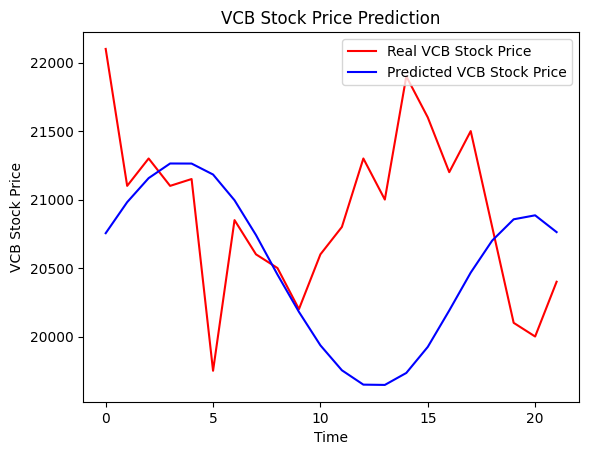

In [30]:
# Ve bieu do gia that va gia du doan
plt.plot(df['Close'][len(df) - 22:].values, color = 'red', label = 'Real VCB Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted VCB Stock Price')
plt.title('VCB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('VCB Stock Price')
plt.legend()
plt.show()

In [31]:
kq=df.loc['2023-02-10':,'Close'].values
kq

array([20500., 20200., 20600., 20800., 21300., 21000., 21900., 21600.,
       21200., 21500., 20800., 20100., 20000., 20400.])

In [32]:
#Du doan gia 7 ngay tiep


dataset_test = df['Close'][len(df) - 22:].values
dataset_test = np.array(dataset_test)
kq=df.loc['2023-02-10':,'Close'].values
inputs = dataset_test
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

i = 0
while i<22:
    X_test = []
    no_of_sample = len(dataset_test)
    # Lay du lieu cuoi cung
    X_test.append(inputs[no_of_sample - 22:, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Du doan gia
    predicted_stock_price = regressor.predict(X_test)

    # chuyen gia tu khoang (0,1) thanh gia that
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    # Them ngay hien tai vao
    dataset_test = np.append(dataset_test, predicted_stock_price[0], axis=0)
    inputs = dataset_test
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)

    print('Stock price ' + str(i+27) + '/2/2023 of VCB : ', predicted_stock_price[0][0])
    kq = np.append(kq,predicted_stock_price[0][0])
    i = i +1



1/1 [==============================] - 0s 43ms/step
Stock price 27/2/2023 of VCB :  20531.215
1/1 [==============================] - 0s 32ms/step
Stock price 28/2/2023 of VCB :  20253.492
1/1 [==============================] - 0s 59ms/step
Stock price 29/2/2023 of VCB :  19990.37
1/1 [==============================] - 0s 52ms/step
Stock price 30/2/2023 of VCB :  19747.736
1/1 [==============================] - 0s 31ms/step
Stock price 31/2/2023 of VCB :  19532.855
1/1 [==============================] - 0s 33ms/step
Stock price 32/2/2023 of VCB :  19336.336
1/1 [==============================] - 0s 40ms/step
Stock price 33/2/2023 of VCB :  19167.24
1/1 [==============================] - 0s 46ms/step
Stock price 34/2/2023 of VCB :  18988.66
1/1 [==============================] - 0s 58ms/step
Stock price 35/2/2023 of VCB :  18813.459
1/1 [==============================] - 0s 56ms/step
Stock price 36/2/2023 of VCB :  18638.945
1/1 [==============================] - 0s 56ms/step
Stock price

In [33]:
kq=kq.reshape(-1,1)
kq

array([[20500.        ],
       [20200.        ],
       [20600.        ],
       [20800.        ],
       [21300.        ],
       [21000.        ],
       [21900.        ],
       [21600.        ],
       [21200.        ],
       [21500.        ],
       [20800.        ],
       [20100.        ],
       [20000.        ],
       [20400.        ],
       [20531.21484375],
       [20253.4921875 ],
       [19990.36914062],
       [19747.73632812],
       [19532.85546875],
       [19336.3359375 ],
       [19167.24023438],
       [18988.66015625],
       [18813.45898438],
       [18638.9453125 ],
       [18467.80859375],
       [18292.3046875 ],
       [18115.65039062],
       [17934.8046875 ],
       [17760.01757812],
       [17576.30664062],
       [17398.44726562],
       [17227.24414062],
       [17053.30078125],
       [16888.50390625],
       [16732.51171875],
       [16577.59570312]])

In [34]:
index=pd.date_range(start='2023/02/10',periods=len(kq),freq='B')
df_predict = pd.DataFrame(data=kq,index=index)
df_predict

,0
2023-02-10,20500.000000
2023-02-13,20200.000000
2023-02-14,20600.000000
2023-02-15,20800.000000
2023-02-16,21300.000000
2023-02-17,21000.000000
2023-02-20,21900.000000
2023-02-21,21600.000000
2023-02-22,21200.000000
2023-02-23,21500.000000


In [35]:
df_50 = df.iloc[-100:,3]
df_50

TradingDate
2022-10-05    19200.0
2022-10-06    18000.0
2022-10-07    17600.0
2022-10-10    18350.0
2022-10-11    17500.0
               ...   
2023-02-23    21500.0
2023-02-24    20800.0
2023-02-27    20100.0
2023-02-28    20000.0
2023-03-01    20400.0
Name: Close, Length: 100, dtype: float64

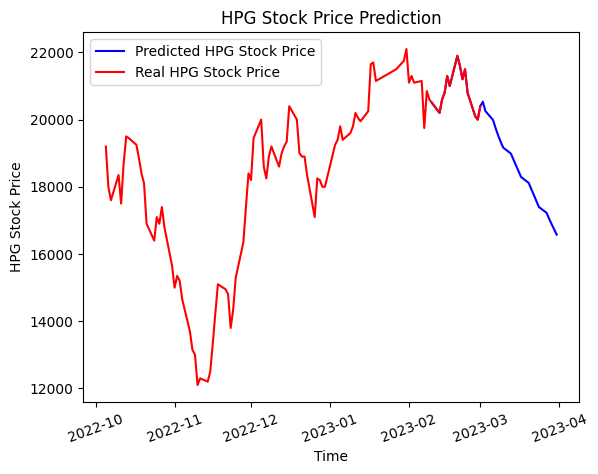

In [36]:
# Ve bieu do gia that va gia du doan
plt.plot(df_predict, color = 'blue', label = 'Predicted HPG Stock Price')
plt.plot(df_50, color = 'red', label = 'Real HPG Stock Price')
plt.title('HPG Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('HPG Stock Price')
plt.legend()
plt.xticks(rotation=20)
plt.show()